In [1]:
import numpy as np
import random
from scipy import linalg as la

In [2]:
def sghmc(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None):
    '''
    Implementation of Stochastic Gradient Hamiltonian Monte Carlo.
    (See details in Chen et al., 2014)
    
    Dimensions in sampling procdure:
        p: dimension of parameters(theta)
        n: number of observed data.
        m: dimension of data.
    
    INPUT:            
        grad_log_den_data: function with parameters (data,theta)
            to compute $\nabla log(p(data|theta))$ (gradient with respect to theta) of a set of data.
            
        grad_log_den_prior: function with parameter (theta)
            to compute $\nabla log(p(theta))$.
            
        data: np.array with shape (n,m)
            representing observed data 
            
        V_hat: np.array with shape (p,p)
            a matrix of estimated Fisher Information 
            
        eps: float or double
            learning rate
            
        theta_0: np.array with shape (p,)
            initial point of sampling.
            
        C: np.array with shape (p,p)
            a matrix representing friction, see paper for details. 
            C-0.5*eps*V_hat must be positive definite.
            
        heatup: int
            iteration to dump before storing sampling points.
            
        epoches: int
            iterations to run. Must be greater than heatup.
        
        batch_size: int
            size of a minibatch in an iteration, hundreds recommended
            
        Minv: np.array with shape (p,p)
            if default(NULL), will be identical. (See paper for details)
            
    OUT:
        sample: np.array with shape (epoches - heatup, p)
            sampled posterior thetas.
    '''
    
    def gradU(grad_log_den_data, grad_log_den_prior, batch, theta, n):
        '''
        inner function to compute $\nabla \tilde{U}$ defined in paper.
        '''
        return(-(n*grad_log_den_data(batch,theta)/batch.shape[0]+grad_log_den_prior(theta)))
    
    
    n,m = data.shape
    p = theta_0.shape[0]
    
    if(Minv is None):
        sqrtM = np.eye(p)
        prer = eps
        fric = eps*C
    else:
        sqrtM = la.sqrtm(la.inv(Minv))
        prer = eps*Minv
        fric = eps*C@Minv

    sqrt_noise = la.sqrtm(2*(C-0.5*eps*V_hat)*eps)
    
    samples = np.zeros((epoches - heatup, p))
    batches = np.int(np.ceil(n/batch_size))
    
    theta = theta_0
    for t in range(epoches):
        if(Minv is None):
            r = np.random.normal(size=(p))
        else:
            r = sqrtM@np.random.normal(size=(p))
        
        split = np.split(data,batches)
        for i in range(batches):
            batch = split[i]
            theta = theta + (prer*r if Minv is None else prer@r)
            gU = gradU(grad_log_den_data,grad_log_den_prior,batch,theta,n)
            r = r - eps*gU - fric@r + sqrt_noise@np.random.normal(size=(p))
        theta = theta + (prer*r if Minv is None else prer@r)
        
        if(t>=heatup):
            samples[t-heatup] = theta
    
    return(samples)


In [3]:
def sghmc_jit(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None):
    '''
    Implementation of Stochastic Gradient Hamiltonian Monte Carlo.
    (See details in Chen et al., 2014)
    
    Dimensions in sampling procdure:
        p: dimension of parameters(theta)
        n: number of observed data.
        m: dimension of data.
    
    INPUT:            
        grad_log_den_data: function with parameters (data,theta)
            to compute $\nabla log(p(data|theta))$ (gradient with respect to theta) of a set of data.
            
        grad_log_den_prior: function with parameter (theta)
            to compute $\nabla log(p(theta))$.
            
        data: np.array with shape (n,m)
            representing observed data 
            
        V_hat: np.array with shape (p,p)
            a matrix of estimated Fisher Information 
            
        eps: float or double
            learning rate
            
        theta_0: np.array with shape (p,)
            initial point of sampling.
            
        C: np.array with shape (p,p)
            a matrix representing friction, see paper for details. 
            C-0.5*eps*V_hat must be positive definite.
            
        heatup: int
            iteration to dump before storing sampling points.
            
        epoches: int
            iterations to run. Must be greater than heatup.
        
        batch_size: int
            size of a minibatch in an iteration, hundreds recommended
            
        Minv: np.array with shape (p,p)
            if default(NULL), will be identical. (See paper for details)
            
    OUT:
        sample: np.array with shape (epoches - heatup, p)
            sampled posterior thetas.
    '''
    
    def gradU(grad_log_den_data, grad_log_den_prior, batch, theta, n):
        '''
        inner function to compute $\nabla \tilde{U}$ defined in paper.
        '''
        return(-(n*grad_log_den_data(batch,theta)/batch.shape[0]+grad_log_den_prior(theta)))

    n,m = data.shape
    p = theta_0.shape[0]
    
    if(Minv is None):
        sqrtM = np.eye(p)
        prer = eps
        fric = eps*C
    else:
        sqrtM = la.sqrtm(la.inv(Minv))
        prer = eps*Minv
        fric = eps*C@Minv

    sqrt_noise = la.sqrtm(2*(C-0.5*eps*V_hat)*eps)
    
    samples = np.zeros((epoches - heatup, p))
    batches = np.int(np.ceil(n/batch_size))
    
    theta = theta_0
    for t in range(epoches):
        if(Minv is None):
            r = np.random.normal(size=(p))
        else:
            r = sqrtM@np.random.normal(size=(p))
        
        split = np.split(data,batches)
        for i in range(batches):
            batch = split[i]
            theta = theta + (prer*r if Minv is None else prer@r)
            gU = gradU(grad_log_den_data,grad_log_den_prior,batch,theta,n)
            r = r - eps*gU - fric@r + sqrt_noise@np.random.normal(size=(p))
        theta = theta + (prer*r if Minv is None else prer@r)
        
        if(t>=heatup):
            samples[t-heatup] = theta
    
    return(samples)


In [4]:
%%file cppfuncs.cpp
<%
cfg['include_dirs'] = ['eigen']
setup_pybind11(cfg)
%>
#include <pybind11/pybind11.h>
#include <pybind11/stl.h>
#include <pybind11/eigen.h>
#include <vector>
#include <random>
#include <Eigen/Dense>
#include <functional>

namespace py = pybind11;
using std::default_random_engine;
using std::normal_distribution;
using std::bind;
using namespace Eigen;
    
//#@jit('double[:](double[:],double[:],double,double[:,:],double[:,:],int32)')
//#def update_r(r,gU,eps,fric,sqrt_noise,p):
//#    return r - eps*gU - fric@r + sqrt_noise@np.random.normal(size=(p))

default_random_engine re{};
normal_distribution<double> norm(0,1);
auto rnorm = bind(norm, re);

VectorXd update_r(VectorXd r, VectorXd gU,double eps,MatrixXd fric,MatrixXd sqrt_noise){
    int p = r.rows();
    VectorXd noise = VectorXd::Zero(p).unaryExpr([](double x){ return rnorm();});
    return r.array() - eps*gU.array() - (fric*r).array() + (sqrt_noise*noise).array();
}

PYBIND11_MODULE(cppfuncs, m) {
    m.def("update_r", &update_r);
}

Overwriting cppfuncs.cpp


In [5]:
import numpy as np
from scipy import linalg as la
import cppimport
cppfuncs = cppimport.imp("cppfuncs")

def sghmc_cpp(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None):
    '''
    Implementation of Stochastic Gradient Hamiltonian Monte Carlo.
    (See details in Chen et al., 2014)
    
    Dimensions in sampling procdure:
        p: dimension of parameters(theta)
        n: number of observed data.
        m: dimension of data.
    
    INPUT:            
        grad_log_den_data: function with parameters (data,theta)
            to compute $\nabla log(p(data|theta))$ (gradient with respect to theta) of a set of data.
            
        grad_log_den_prior: function with parameter (theta)
            to compute $\nabla log(p(theta))$.
            
        data: np.array with shape (n,m)
            representing observed data 
            
        V_hat: np.array with shape (p,p)
            a matrix of estimated Fisher Information 
            
        eps: float or double
            learning rate
            
        theta_0: np.array with shape (p,)
            initial point of sampling.
            
        C: np.array with shape (p,p)
            a matrix representing friction, see paper for details. 
            C-0.5*eps*V_hat must be positive definite.
            
        heatup: int
            iteration to dump before storing sampling points.
            
        epoches: int
            iterations to run. Must be greater than heatup.
        
        batch_size: int
            size of a minibatch in an iteration, hundreds recommended
            
        Minv: np.array with shape (p,p)
            if default(NULL), will be identical. (See paper for details)
            
    OUT:
        sample: np.array with shape (epoches - heatup, p)
            sampled posterior thetas.
    '''
    
    def gradU(grad_log_den_data, grad_log_den_prior, batch, theta, n):
        '''
        inner function to compute $\nabla \tilde{U}$ defined in paper.
        '''
        return(-(n*grad_log_den_data(batch,theta)/batch.shape[0]+grad_log_den_prior(theta)))

    n,m = data.shape
    p = theta_0.shape[0]
    
    if(Minv is None):
        sqrtM = np.eye(p)
        prer = eps
        fric = eps*C
    else:
        sqrtM = la.sqrtm(la.inv(Minv))
        prer = eps*Minv
        fric = eps*C@Minv

    sqrt_noise = la.sqrtm(2*(C-0.5*eps*V_hat)*eps)
    
    samples = np.zeros((epoches - heatup, p))
    batches = np.int(np.ceil(n/batch_size))
    
    theta = theta_0
    for t in range(epoches):
        if(Minv is None):
            r = np.random.normal(size=(p))
        else:
            r = sqrtM@np.random.normal(size=(p))
        
        split = np.split(data,batches)
        for i in range(batches):
            batch = split[i]
            theta = theta + (prer*r if Minv is None else prer@r)
            gU = gradU(grad_log_den_data,grad_log_den_prior,batch,theta,n)
            r = cppfuncs.update_r(r,gU,eps,fric,sqrt_noise)
        theta = theta + (prer*r if Minv is None else prer@r)
        
        if(t>=heatup):
            samples[t-heatup] = theta
    
    return(samples)


In [6]:
import numpy as np
from scipy import linalg as la
import cppimport
cppfuncs = cppimport.imp("cppfuncs")

def sghmc_cpp_noM(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size):
    '''
    Implementation of Stochastic Gradient Hamiltonian Monte Carlo.
    (See details in Chen et al., 2014)
    
    Dimensions in sampling procdure:
        p: dimension of parameters(theta)
        n: number of observed data.
        m: dimension of data.
    
    INPUT:            
        grad_log_den_data: function with parameters (data,theta)
            to compute $\nabla log(p(data|theta))$ (gradient with respect to theta) of a set of data.
            
        grad_log_den_prior: function with parameter (theta)
            to compute $\nabla log(p(theta))$.
            
        data: np.array with shape (n,m)
            representing observed data 
            
        V_hat: np.array with shape (p,p)
            a matrix of estimated Fisher Information 
            
        eps: float or double
            learning rate
            
        theta_0: np.array with shape (p,)
            initial point of sampling.
            
        C: np.array with shape (p,p)
            a matrix representing friction, see paper for details. 
            C-0.5*eps*V_hat must be positive definite.
            
        heatup: int
            iteration to dump before storing sampling points.
            
        epoches: int
            iterations to run. Must be greater than heatup.
        
        batch_size: int
            size of a minibatch in an iteration, hundreds recommended
            
        Minv: np.array with shape (p,p)
            if default(NULL), will be identical. (See paper for details)
            
    OUT:
        sample: np.array with shape (epoches - heatup, p)
            sampled posterior thetas.
    '''
    
    def gradU(grad_log_den_data, grad_log_den_prior, batch, theta, n):
        '''
        inner function to compute $\nabla \tilde{U}$ defined in paper.
        '''
        return(-(n*grad_log_den_data(batch,theta)/batch.shape[0]+grad_log_den_prior(theta)))

    n,m = data.shape
    p = theta_0.shape[0]

    fric = eps*C

    sqrt_noise = la.sqrtm(2*(C-0.5*eps*V_hat)*eps)
    
    samples = np.zeros((epoches - heatup, p))
    batches = np.int(np.ceil(n/batch_size))
    
    theta = theta_0
    for t in range(epoches):
        r = np.random.normal(size=(p))
        
        split = np.split(data,batches)
        for i in range(batches):
            batch = split[i]
            theta = theta + eps*r
            gU = gradU(grad_log_den_data,grad_log_den_prior,batch,theta,n)
            r = cppfuncs.update_r(r,gU,eps,fric,sqrt_noise)
        theta = theta + eps*r
        
        if(t>=heatup):
            samples[t-heatup] = theta
    
    return(samples)


## cpp opt

In [33]:
data = np.array(list(range(100)))+2*np.random.normal(size=(10000,100))
V_hat=np.eye(100)
eps=0.01
theta_0=np.zeros(100)
C=np.eye(100)
heatup=100
epoches=200
batch_size=500

def gradU(grad_log_den_data, grad_log_den_prior, batch, theta, n):
        '''
        inner function to compute $\nabla \tilde{U}$ defined in paper.
        '''
        return(-(n*grad_log_den_data(batch,theta)/batch.shape[0]+grad_log_den_prior(theta)))

n,m = data.shape
p = theta_0.shape[0]

fric = eps*C

sqrt_noise = la.sqrtm(2*(C-0.5*eps*V_hat)*eps)

samples = np.zeros((epoches - heatup, p))
batches = np.int(np.ceil(n/batch_size))

theta = theta_0

In [34]:
r = np.random.normal(size=(p))
        
split = np.split(data,batches)
for i in range(batches):
    batch = split[i]
    theta = theta + eps*r
    gU = gradU(grad_log_den_data,grad_log_den_prior,batch,theta,n)
    r = cppfuncs.update_r(r,gU,eps,fric,sqrt_noise)
theta = theta + eps*r

In [35]:
%timeit np.random.normal(size=(p))
%timeit np.split(data,batches)
%timeit theta + eps*r
%timeit gradU(grad_log_den_data,grad_log_den_prior,batch,theta,n)
%timeit cppfuncs.update_r(r,gU,eps,fric,sqrt_noise)

6.81 µs ± 29.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
35.3 µs ± 548 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
1.09 µs ± 4.67 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
89.7 µs ± 289 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
29.3 µs ± 98.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
%timeit gradU(grad_log_den_data_jit,grad_log_den_prior_jit,batch,theta,n)

80 µs ± 507 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [38]:
%timeit r - eps*gU - fric@r + sqrt_noise@np.random.normal(size=(p))

22.7 µs ± 814 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## time

In [76]:
def grad_log_den_data(data,theta):
    return(np.sum(data-theta,axis=0))

def grad_log_den_prior(theta):
    return(-theta)

import numba
from numba import jit
@jit('double[:](double[:,:],double[:])')
def grad_log_den_data_jit(data,theta):
    return(np.sum(data-theta,axis=0))

@jit('double[:](double[:])')
def grad_log_den_prior_jit(theta):
    return(-theta)

dnorm=1000
data = np.array(list(range(dnorm)))+2*np.random.normal(size=(10000,dnorm))
V_hat=np.eye(dnorm)
eps=0.01
theta_0=np.zeros(dnorm)
C=np.eye(dnorm)
heatup=100
epoches=200
batch_size=500

In [8]:
%timeit sghmc(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)
%timeit sghmc_jit(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)
%timeit sghmc_cpp(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)

5.01 s ± 62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.89 s ± 52.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
19.1 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit sghmc_cpp_noM(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size)

492 ms ± 4.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
sghmc(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = None)

array([[-0.15807424,  1.01034599,  1.83609643, ..., 97.05898675,
        98.04735348, 98.97711129],
       [-0.18926992,  0.99169964,  1.88192535, ..., 96.93019707,
        97.9011416 , 98.88606449],
       [-0.1530833 ,  1.01816102,  1.83819022, ..., 97.03696292,
        98.0415609 , 98.97156504],
       ...,
       [-0.17963601,  1.01113095,  1.87209616, ..., 96.95619933,
        97.98494918, 98.93137916],
       [-0.16956746,  0.987409  ,  1.84164769, ..., 97.01577784,
        97.97021751, 98.93303963],
       [-0.17911804,  1.01706299,  1.8731486 , ..., 96.96036453,
        97.98539675, 98.93018898]])

In [ ]:
sghmc(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = np.eye(2))

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
sample=sghmc(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, Minv = np.eye(2))
plt.figure(figsize=(5,5))
plt.scatter(*sample.T)
plt.show()

# MultiProcess

In [79]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [80]:
def sghmc_chains(grad_log_den_data, grad_log_den_prior, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, chain = 1, Minv = None):
    '''
    Implementation of Stochastic Gradient Hamiltonian Monte Carlo.
    (See details in Chen et al., 2014)
    
    Dimensions in sampling procdure:
        p: dimension of parameters(theta)
        n: number of observed data.
        m: dimension of data.
    
    INPUT:            
        grad_log_den_data: function with parameters (data,theta)
            to compute $\nabla log(p(data|theta))$ (gradient with respect to theta) of a set of data.
            
        grad_log_den_prior: function with parameter (theta)
            to compute $\nabla log(p(theta))$.
            
        data: np.array with shape (n,m)
            representing observed data 
            
        V_hat: np.array with shape (p,p)
            a matrix of estimated Fisher Information 
            
        eps: float or double
            learning rate
            
        theta_0: np.array with shape (p,)
            initial point of sampling.
            
        C: np.array with shape (p,p)
            a matrix representing friction, see paper for details. 
            C-0.5*eps*V_hat must be positive definite.
            
        heatup: int
            iteration to dump before storing sampling points.
            
        epoches: int
            iterations to run. Must be greater than heatup.
        
        batch_size: int
            size of a minibatch in an iteration, hundreds recommended
            
        Minv: np.array with shape (p,p)
            if default(NULL), will be identical. (See paper for details)
            
    OUT:
        sample: np.array with shape (epoches - heatup, p)
            sampled posterior thetas.
    '''
    
    def gradU(grad_log_den_data, grad_log_den_prior, batch, theta, n):
        '''
        inner function to compute $\nabla \tilde{U}$ defined in paper.
        '''
        return(-(n*grad_log_den_data(batch,theta)/batch.shape[0]+grad_log_den_prior(theta)))

    n,m = data.shape
    p = theta_0.shape[0]
    
    if(Minv is None):
        sqrtM = np.eye(p)
        prer = eps
        fric = eps*C
    else:
        sqrtM = la.sqrtm(la.inv(Minv))
        prer = eps*Minv
        fric = eps*C@Minv

    sqrt_noise = la.sqrtm(2*(C-0.5*eps*V_hat)*eps)
    
    batches = np.int(np.ceil(n/batch_size))
    
    #ProcessPoolExecutor 
    def single_chain():
        theta = theta_0
        samples = np.zeros((epoches - heatup, p))
        for t in range(epoches):
            if(Minv is None):
                r = np.random.normal(size=(p))
            else:
                r = sqrtM@np.random.normal(size=(p))

            split = np.split(data,batches)
            for i in range(batches):
                batch = split[i]
                theta = theta + (prer*r if Minv is None else prer@r)
                gU = gradU(grad_log_den_data,grad_log_den_prior,batch,theta,n)
                r = r - eps*gU - fric@r + sqrt_noise@np.random.normal(size=(p))
            theta = theta + (prer*r if Minv is None else prer@r)

            if(t>=heatup):
                samples[t-heatup] = theta
        
        return(samples)
    
    with ProcessPoolExecutor(max_workers=chain) as pool:
        res = pool.map(single_chain)
    
    return(list(res))


In [ ]:
def grad_log_den_data(data,theta):
    return(np.sum(data-theta,axis=0))

def grad_log_den_prior(theta):
    return(-theta)

import numba
from numba import jit
@jit('double[:](double[:,:],double[:])')
def grad_log_den_data_jit(data,theta):
    return(np.sum(data-theta,axis=0))

@jit('double[:](double[:])')
def grad_log_den_prior_jit(theta):
    return(-theta)

In [92]:
dnorm=10
data = np.array(list(range(dnorm)))+2*np.random.normal(size=(100,dnorm))
V_hat=np.eye(dnorm)
eps=0.01
theta_0=np.zeros(dnorm)
C=np.eye(dnorm)
heatup=100
epoches=200
batch_size=20
chain=2

def gradU(grad_log_den_data, grad_log_den_prior, batch, theta, n):
    '''
    inner function to compute $\nabla \tilde{U}$ defined in paper.
    '''
    return(-(n*grad_log_den_data(batch,theta)/batch.shape[0]+grad_log_den_prior(theta)))

n,m = data.shape
p = theta_0.shape[0]

prer = eps
fric = eps*C

sqrt_noise = la.sqrtm(2*(C-0.5*eps*V_hat)*eps)

batches = np.int(np.ceil(n/batch_size))

#ProcessPoolExecutor 
def single_chain():
    theta = theta_0
    samples = np.zeros((epoches - heatup, p))
    for t in range(epoches):
        r = np.random.normal(size=(p))

        split = np.split(data,batches)
        for i in range(batches):
            batch = split[i]
            theta = theta + prer*r
            gU = gradU(grad_log_den_data,grad_log_den_prior,batch,theta,n)
            r = r - eps*gU - fric@r + sqrt_noise@np.random.normal(size=(p))
        theta = theta + prer*r

        if(t>=heatup):
            samples[t-heatup] = theta

    return(samples)

with ProcessPoolExecutor(max_workers=chain) as pool:
    res = pool.map(single_chain)
    
list(res)

[]

In [106]:
with ProcessPoolExecutor(max_workers=2) as pool:
    res = pool.map(single_chain,[])

In [110]:
p=10
def f_():
    r = 1
    return(r)

with ProcessPoolExecutor(max_workers=2) as pool:
    res = pool.map(f_,[])
    
list(res)

[]

In [119]:
import math
def func_compute_intesnive(n):
    s = 0
    for i in range(1, n+1):
        s += math.exp(math.log(math.sqrt(math.pow(i, 2.0))))
    return s

n=10

with ProcessPoolExecutor(max_workers=4) as pool:
    ans = pool.map(func_compute_intesnive, [n,n,n,n])

In [120]:
list(ans)

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [107]:
np.array(res)

array(<itertools.chain object at 0x00000229845AAE10>, dtype=object)

In [101]:
res[0]

TypeError: 'itertools.chain' object is not subscriptable

In [93]:
single_chain()

array([[ 1.34076585e-01,  1.04537093e+00,  2.05589815e+00,
         2.99943723e+00,  4.04761437e+00,  4.69769460e+00,
         5.60505498e+00,  7.05607591e+00,  7.77191024e+00,
         8.71665209e+00],
       [ 1.16366979e-01,  1.16035357e+00,  2.15506664e+00,
         3.05450196e+00,  4.07714385e+00,  4.79921455e+00,
         5.61333283e+00,  7.13560166e+00,  7.81101110e+00,
         8.60927995e+00],
       [ 2.19169759e-01,  1.18619562e+00,  2.17481276e+00,
         2.97081101e+00,  4.13286490e+00,  4.79737010e+00,
         5.51423354e+00,  7.19349247e+00,  7.79304027e+00,
         8.71408640e+00],
       [ 1.44097499e-01,  1.13867347e+00,  2.27075533e+00,
         2.97979551e+00,  4.23126218e+00,  4.83409187e+00,
         5.41216414e+00,  7.13164126e+00,  7.73372375e+00,
         8.72605425e+00],
       [ 1.38920661e-01,  1.02997775e+00,  2.24374821e+00,
         2.87104094e+00,  4.23853888e+00,  4.80531468e+00,
         5.39233809e+00,  7.15150862e+00,  7.74775053e+00,
         8.

In [83]:
sghmc_chains(grad_log_den_data_jit, grad_log_den_prior_jit, data, V_hat, eps, theta_0, C, heatup, epoches, batch_size, 2)

[]

# Mixture normal

In [4]:
mu = np.array([-3, 3]).reshape(2,1) # true value for mu
n = 200 # number of observations
y = np.array([np.random.normal(mu[0], 1, n),np.random.normal(mu[1], 1, n)]).flatten() # observations

In [5]:
y.shape

(400,)

In [30]:
def mn_glpdf(y,mu):
    exp1=np.exp(-0.5*(y-mu[0])**2)
    exp2=np.exp(-0.5*(y-mu[1])**2)
    
    v = np.c_[exp1*(y-mu[0]),exp2*(y-mu[1])]
    return np.sum(v/(exp1+exp2),axis=0)

def mn_glpr(mu):
    return -(np.sum(mu)/100)

In [32]:
mn_glpdf(y[:,None],mu)

array([-27.97542765,  -3.84259246])

C:\Users\Senlo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


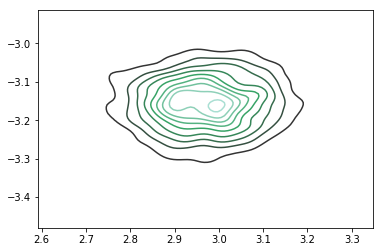

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

sim = sghmc(mn_glpdf, mn_glpr, y[:,None], V_hat = np.eye(2), eps = 0.01, 
            theta_0 = np.array([0,0]), C = np.eye(2), 
            heatup = 100, epoches = 2000, batch_size = 80)

kdeplt2 = sns.kdeplot(sim[:,0],sim[:,1])  
plt.show()

In [41]:
np.min(sim[:,0])

2.6690826186731313

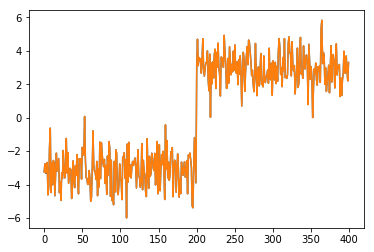

In [43]:
plt.plot(y)
plt.show()